In [1]:
# good article:
# https://ml.berkeley.edu/blog/2018/01/10/adversarial-examples/
# paper:
# https://arxiv.org/abs/1412.6572

In [81]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
def mse(y, yhat):
    return np.mean(np.power(y - yhat, 2))

In [83]:
w = pd.read_csv('./wb_model.tsv', sep='\t', header=None).values
test = pd.read_csv('./images.tsv', sep='\t', header=None).values
labels = test[:, -1]
test = test[:, :-1]

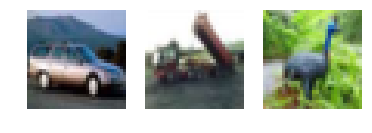

In [84]:
# input images 
for i in range(3):
    plt.subplot(131 + i)
    plt.imshow(test[i].reshape(32, 32, -1).astype('uint8'))
    plt.axis('off')

In [106]:
def normalize(img):
    return img * 0.01 - 1.28

def inverse(img):
    return ((img + 1.28) * 100).astype('uint8')
    
def model_prediction(w, x, to_int=False):
    if to_int:
        x = inverse(x).astype('uint8')
        x = normalize(x)
    h = w @ x
    e = np.exp(h)
    y = e / np.sum(e, axis=0)
    return y

In [107]:
# sanity check 
x = test[0].copy()
pred = model_prediction(w, normalize(x))
print(np.argmax(pred), np.max(pred))
print(pred)

1 0.42214679305999825
[0.08050729 0.42214679 0.02815839 0.01158023 0.01169259 0.00528199
 0.01472759 0.02145053 0.18641341 0.21804119]


In [108]:
def target_adversarial_attack(x, lr, reg, n_class, target_class, n_epochs, predict):
    
    x_hat = x.copy()
    y = np.zeros(n_class)
    y[target_class] = 1
    for e in range(n_epochs):
        y_hat = predict(w, x_hat)
        grad = lr * ( w.T @ (y_hat - y) + reg * (x_hat - x) )
        x_hat = (x_hat - grad).clip(-1.28, 1.27)
        p = predict(w, x_hat, True)[target_class]
        #if e % 200 == 0: print(e, p)
        if p > 0.5:
            return x_hat

# hyper parameters
lr = 0.01
reg = 0.05
n_epochs = 100000
n_class = 10

# loop by images 
adv_img = []
errors = []
for i in range(labels.shape[0]):
    x = test[i].copy()
    target_class = labels[i]
    adv = target_adversarial_attack(normalize(x), lr, reg, 
                                    n_class, target_class, n_epochs, model_prediction)
    adv = inverse(adv)
    adv_img.append(adv)
    errors.append(mse(x, adv))

In [109]:
np.mean(errors), errors

(75.54166666666667, [106.61458333333333, 23.017252604166668, 96.9931640625])

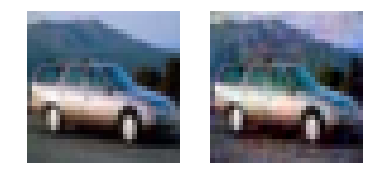

In [110]:
plt.subplot(121)
plt.axis('off')
plt.imshow(test[0].reshape(32, 32, -1).astype('uint8'))
plt.subplot(122)
plt.axis('off')
plt.imshow(adv_img[0].reshape(32, 32, -1).astype('uint8'))

In [114]:
# sanity check 2
for i in range(3):
    yhat = model_prediction(w, normalize(adv_img[i]))
    print(np.argmax(yhat) == labels[i], np.max(yhat))

True 0.5001311167273227
True 0.5003828369716513
True 0.5002385649651111


In [115]:
fout = open("output.txt", "w")
for img in adv_img:
    fout.write(' '.join(map(str, img.tolist())))
    fout.write('\n')
fout.close()

In [112]:
np.savetxt('out.txt', np.array(adv_img), '%d')